# Import Libs

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, recall_score, precision_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Preprocessing

Define mark which will  set min mark limit

In [110]:
data = pd.read_excel('dataset.xlsx')
data.dropna

min_mark = 4

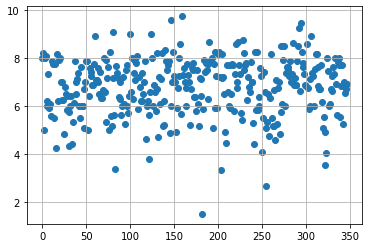

In [111]:
x = range(len(data['Средний балл']))
y = data['Средний балл']

plt.scatter(x, y)
plt.grid()
plt.show()

In [112]:
# Replase mark of student by belonging to the class of successfully passed
data['Сдал'] = pd.cut(x=data['Средний балл'], bins=[0, min_mark, 10], labels=[0, 1])
data.drop(['Средний балл'], axis = 1, inplace= True)

# Drop indicators which are not connected with extracurricular activities
data.drop([ 'Учащийся',
            'Дата прохождения теста',
            '15.Образование Ваших родителей?', 
            '3.С какими оценками Вы закончили школу?',
            '4.Ходили ли Вы на подготовительные курсы перед поступлением в вуз?',
            '7.Какая у Вас семья?',
            '10.Получали ли Вы стипендию? (в течение последнего года)',
            '11.Оцените, как Вам нравится учиться?'],
            axis = 1, inplace = True)
            
data.head()

,17.Укажите Ваше семейное положение.,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,13.На какие средства Вы живете?,12.Каковы условия Вашего проживания?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,5.Брали ли Вы академический отпуск?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?,Сдал
0,Холост/не замужем,Нет,"нет, не занимаюсь",Получаете стипендию;Деньги дают родные,Живете с родителями/родными/супругом,Более 3 часов в день,Не пропускаете,Нет,Нет,нет,"Нет, но собираюсь в этом году",1
1,Живу с мч/девушкой,Да,"нет, не занимаюсь",Работаете;Деньги дают родные,Живете с друзьями в собственной/съемной квартире,Готовлюсь только перед занятиями,Регулярно пропускаете,Всегда,Нет,нет,Нет,1
2,Холост/не замужем,Нет,"нет, не занимаюсь",Получаете стипендию;Деньги дают родные,Живете в общежитии,Более 3 часов в день,Не пропускаете,Нет,Нет,нет,Нет,1
3,Холост/не замужем,Нет,"да, занимаюсь шахматами/шашками;нет, не занимаюсь",Деньги дают родные,Живете с родителями/родными/супругом,Более 3 часов в день,Среднее количество пропусков,1-2 раза в год,Нет,нет,Да,1
4,Холост/не замужем,Нет,"да, занимаюсь командными видами спорта (футбол...",Деньги дают родные,Живете с друзьями в собственной/съемной квартире,Более 3 часов в день,Не пропускаете,Нет,Нет,нет,Нет,1


Lets find out how many students did not pass the exams

In [113]:
passed = 0
not_passed = 0
res = 0
for i in data['Сдал']:
    if i == 1:
        passed += 1
    elif i == 0:
        not_passed += 1
    res += 1
print(f"TOTAL: {res}\nPassed: {passed}\nNot pas: {not_passed}")

TOTAL: 435
Passed: 341
Not pas: 6


Split our data in 3 parts for train, test and validation

In [114]:
def train_test_val_split(train_ratio=0.75, test_ratio=0.10, validation_ratio=0.15):
    label_encoder = LabelEncoder()

    s = (data.dtypes == 'object')
    object_cols = list(s[s].index)
    label_data = data.copy()
    for col in object_cols:
        label_encoder.fit(data[col])
        label_data[col] = label_encoder.transform(data[col])

    X_train, X_test, y_train, y_test = train_test_split(label_data.drop('Сдал', axis = 1), 
                                                        label_data['Сдал'], 
                                                        test_size=1-train_ratio,
                                                        random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(  X_train,
                                                        y_train, 
                                                        test_size=test_ratio/(test_ratio + validation_ratio), 
                                                        random_state=1)

    return X_train, X_test, X_val, y_train, y_test, y_val

In [115]:
#will be replaced by train_test_val_split()
def evel_split():
    train = data.loc[:346, :]
    val = data.loc[347:, :].drop('Сдал', axis = 1)

    s = (train.dtypes == 'object')
    object_cols = list(s[s].index)


    label_train = train.copy()
    label_val = val.copy()

    label_encoder = LabelEncoder()

    for col in object_cols:
        label_encoder.fit(data[col])
        label_train[col] = label_encoder.transform(train[col])
        label_val[col] = label_encoder.transform(val[col])

    X_train, X_test, y_train, y_test = train_test_split(label_train.drop('Сдал', axis = 1), 
                                                        label_train['Сдал'], test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [116]:
X_train, X_test, y_train, y_test = evel_split()
#X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(train_ratio=0.75, test_ratio=0.10, validation_ratio=0.15)

# Model variants
In that part I will choose the classification model which will predict if student pass exams successfully or not

## Metrics Functions

In [117]:
def classification_quality(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("F1:", f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
    print("Weighted Recall:", (precision_recall_fscore_support(y_test, y_pred, average='macro')))

In [118]:
def regression_quality(y_test, y_pred):
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("RMSE:", mean_squared_error(y_test, y_pred)**(1/2))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2:", r2_score(y_test, y_pred))

In [119]:
metrics_list = ['Accuracy', 'Balanced Accuracy', 'Recall', 'Precision', 'F1', 'MSE', 'RMSE', 'MAE', 'R2']
model_array = []
output_array = []

def compilance_print(model, y_test, y_pred, model_flag):
    temp_array = []
    if model_flag == 'cls': # classifier
        temp_array.append(accuracy_score(y_test, y_pred))
        temp_array.append(balanced_accuracy_score(y_test, y_pred))
        temp_array.append(recall_score(y_test, y_pred, average='macro'))
        temp_array.append(precision_score(y_test, y_pred, average='macro'))
        temp_array.append(f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
        for i in range(4): temp_array.append(None)
    elif model_flag == 'reg': # regression
        for i in range(5): temp_array.append(None)
        temp_array.append(mean_squared_error(y_test, y_pred))
        temp_array.append(mean_squared_error(y_test, y_pred)**(1/2))
        temp_array.append(mean_absolute_error(y_test, y_pred))
        temp_array.append(r2_score(y_test, y_pred))
    else: 
        print('Error')
        for i in range(len(metrics_list)): temp_array.append(None)

    model_indx = -1
    flag = 1
    for indx, _model in enumerate(model_array):
        if _model == model:
            model_indx = indx
            flag = 0
    if flag:
        output_array.append([0]* len(metrics_list))
        model_indx = len(model_array)
        model_array.append(model)
    for indx, el in enumerate(temp_array):
        output_array[model_indx][indx] = el

In [120]:
def graph_show(model, X_test, y_test):
    metrics.plot_confusion_matrix(model, X_test, y_test) 
    metrics.plot_roc_curve(model, X_test, y_test)
    plt.show()

## Classifier

### Perception Classifier Model

In [121]:
from sklearn.linear_model import Perceptron
Perc = Perceptron()
Perc.fit(X_train, y_train)

y_pred = Perc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('Perceptron', y_test, y_pred, 'cls')


Accuracy: 0.9714285714285714
Recall: 0.5
Precision: 0.4857142857142857
F1: 0.9855072463768115
Weighted Recall: (0.4857142857142857, 0.5, 0.49275362318840576, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest Classifier Model

In [122]:
from sklearn.ensemble import RandomForestClassifier
RanF = RandomForestClassifier()
RanF.fit(X_train, y_train)

y_pred = RanF.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('RandomForest', y_test, y_pred, 'cls')


Accuracy: 0.9714285714285714
Recall: 0.5
Precision: 0.4857142857142857
F1: 0.9855072463768115
Weighted Recall: (0.4857142857142857, 0.5, 0.49275362318840576, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Gradient Boosting Classifier Model

In [123]:
from sklearn.ensemble import GradientBoostingClassifier
GraB = GradientBoostingClassifier()
GraB.fit(X_train, y_train)

y_pred = GraB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GradientBoosting', y_test, y_pred, 'cls')

Accuracy: 0.9714285714285714
Recall: 0.5
Precision: 0.4857142857142857
F1: 0.9855072463768115
Weighted Recall: (0.4857142857142857, 0.5, 0.49275362318840576, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### MultinomialNB Classifier Model

In [124]:
from sklearn.naive_bayes import MultinomialNB
MulNB = MultinomialNB()
MulNB.fit(X_train, y_train)

y_pred = MulNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MultinomialNB', y_test, y_pred, 'cls')

Accuracy: 0.8380952380952381
Recall: 0.43137254901960786
Precision: 0.4835164835164835
F1: 0.4559585492227979
Weighted Recall: (0.4835164835164835, 0.43137254901960786, 0.4559585492227979, None)


### ComplementNB Classifier Model

In [125]:
from sklearn.naive_bayes import ComplementNB
ComNB = ComplementNB()
ComNB.fit(X_train, y_train)

y_pred = ComNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('ComplementNB', y_test, y_pred, 'cls')

Accuracy: 0.7714285714285715
Recall: 0.39705882352941174
Precision: 0.48214285714285715
F1: 0.43548387096774194
Weighted Recall: (0.48214285714285715, 0.39705882352941174, 0.43548387096774194, None)


### GaussianNB Classifier Model

In [126]:
from sklearn.naive_bayes import GaussianNB
GaNB = GaussianNB()
GaNB.fit(X_train, y_train)

y_pred = GaNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GaussianNB', y_test, y_pred, 'cls')

Accuracy: 0.9142857142857143
Recall: 0.6323529411764706
Precision: 0.5521907216494846
F1: 0.5682960255824577
Weighted Recall: (0.5521907216494846, 0.6323529411764706, 0.5682960255824577, None)


### CategoricalNB Classifier Model

In [127]:
from sklearn.naive_bayes import CategoricalNB
CatNB = CategoricalNB()
CatNB.fit(X_train, y_train)

y_pred = CatNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('CategoricalNB', y_test, y_pred, 'cls')

Accuracy: 0.9619047619047619
Recall: 0.4950980392156863
Precision: 0.4855769230769231
F1: 0.49029126213592233
Weighted Recall: (0.4855769230769231, 0.4950980392156863, 0.49029126213592233, None)


### BernoulliNB Classifier Model

In [128]:
from sklearn.naive_bayes import BernoulliNB
BerNB = BernoulliNB()
BerNB.fit(X_train, y_train)

y_pred = BerNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('BernoulliNB', y_test, y_pred, 'cls')

Accuracy: 0.9714285714285714
Recall: 0.5
Precision: 0.4857142857142857
F1: 0.9855072463768115
Weighted Recall: (0.4857142857142857, 0.5, 0.49275362318840576, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVC Classifier Model

In [129]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('SVC', y_test, y_pred, 'cls')

Accuracy: 0.9714285714285714
Recall: 0.5
Precision: 0.4857142857142857
F1: 0.9855072463768115
Weighted Recall: (0.4857142857142857, 0.5, 0.49275362318840576, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LinearSVC Classifier Model

In [130]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)

y_pred = lsvc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('LinearSVC', y_test, y_pred, 'cls')

Accuracy: 0.9714285714285714
Recall: 0.5
Precision: 0.4857142857142857
F1: 0.9855072463768115
Weighted Recall: (0.4857142857142857, 0.5, 0.49275362318840576, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarn

### OneClassSVM Classifier Model

In [131]:
from sklearn.svm import OneClassSVM
oclsvc = OneClassSVM()
oclsvc.fit(X_train, y_train)

y_pred = oclsvc.predict(X_test)

classification_quality(y_test, y_pred)
#compilance_print('OneClassSVM', y_test, y_pred, 'cls')

Accuracy: 0.4666666666666667
Recall: 0.16013071895424838
Precision: 0.3141025641025641
F1: 0.3181818181818182
Weighted Recall: (0.3141025641025641, 0.16013071895424838, 0.21212121212121213, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/py

### DecisionTreeClassifier Model

In [132]:
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('DecisionTreeClassifier', y_test, y_pred, 'cls')

Accuracy: 0.9523809523809523
Recall: 0.49019607843137253
Precision: 0.4854368932038835
F1: 0.4878048780487805
Weighted Recall: (0.4854368932038835, 0.49019607843137253, 0.4878048780487805, None)


### ExtraTreeClassifier Model

In [133]:
from sklearn.tree import plot_tree, ExtraTreeClassifier
extr = ExtraTreeClassifier()
extr.fit(X_train, y_train)

y_pred = extr.predict(X_test)

#plot_tree(extr)
classification_quality(y_test, y_pred)
compilance_print('ExtraTreeClassifier', y_test, y_pred, 'cls')

Accuracy: 0.9523809523809523
Recall: 0.49019607843137253
Precision: 0.4854368932038835
F1: 0.4878048780487805
Weighted Recall: (0.4854368932038835, 0.49019607843137253, 0.4878048780487805, None)


### MLPClassifier Model

In [134]:
from sklearn.neural_network import MLPClassifier
MLPCl = MLPClassifier()
MLPCl.fit(X_train, y_train)

y_pred = MLPCl.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MLPClassifier', y_test, y_pred, 'cls')

Accuracy: 0.9714285714285714
Recall: 0.5
Precision: 0.4857142857142857
F1: 0.9855072463768115
Weighted Recall: (0.4857142857142857, 0.5, 0.49275362318840576, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245:

## Matrix
That table helps to understand which model is better for my work

In [135]:
pd.DataFrame(index=metrics_list, columns=model_array, data=np.array(pd.DataFrame(output_array).T))

,Perceptron,RandomForest,GradientBoosting,MultinomialNB,ComplementNB,GaussianNB,CategoricalNB,BernoulliNB,SVC,LinearSVC,DecisionTreeClassifier,ExtraTreeClassifier,MLPClassifier
Accuracy,0.971429,0.971429,0.971429,0.838095,0.771429,0.914286,0.961905,0.971429,0.971429,0.971429,0.952381,0.952381,0.971429
Balanced Accuracy,0.5,0.5,0.5,0.431373,0.397059,0.632353,0.495098,0.5,0.5,0.5,0.490196,0.490196,0.5
Recall,0.5,0.5,0.5,0.431373,0.397059,0.632353,0.495098,0.5,0.5,0.5,0.490196,0.490196,0.5
Precision,0.485714,0.485714,0.485714,0.483516,0.482143,0.552191,0.485577,0.485714,0.485714,0.485714,0.485437,0.485437,0.485714
F1,0.985507,0.985507,0.985507,0.455959,0.435484,0.568296,0.490291,0.985507,0.985507,0.985507,0.487805,0.487805,0.985507
MSE,None,None,None,None,None,None,None,None,None,None,None,None,None
RMSE,None,None,None,None,None,None,None,None,None,None,None,None,None
MAE,None,None,None,None,None,None,None,None,None,None,None,None,None
R2,None,None,None,None,None,None,None,None,None,None,None,None,None


I choose model X due to its statistics

In [136]:
my_model = MLPCl

# Validation

In [137]:
data = pd.read_excel('dataset.xlsx')
students = data[347:].drop('Средний балл', axis = 1)

In [141]:
students.loc[:, 'Сдал'] = my_model.predict(data[347:])
students.index += 1 

ValueError: could not convert string to float: 'Анисимов Степан Евгеньевич'

In [ ]:
students[students['Сдал'] == 0]['Учащийся']